# cmip Impacts 

This file makes lots of contour plots for rainfall and temperature anomalies under different individal and compound event types



In [86]:
#import my functions
import utils._modelDefinitions as _model
%run helpers/impactPlots.ipynb


In [2]:
import xarray
import numpy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


In [3]:
indexSet='ecCombinedDmiSam'
resultsDir='results/cmipImpact/'

# Import Events

In [4]:
allEvents=xarray.open_dataset('results/cmipEcEvents.nc')

In [5]:
allEvents

<xarray.Dataset>
Dimensions:     (experiment: 2, fire: 2, model: 38, year: 5343)
Coordinates:
  * year        (year) int64 1 2 3 4 5 6 7 ... 7888 7889 7890 7891 7892 7893
  * experiment  (experiment) object 'piControl' 'ssp585'
  * model       (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * fire        (fire) object 'pos' 'neg'
Data variables:
    cIndex      (fire, model, year, experiment) float64 ...
    eIndex      (fire, model, year, experiment) float64 ...
    ecCombined  (fire, model, year, experiment) float64 ...
    dmi         (fire, experiment, model, year) float64 ...
    nino4       (fire, experiment, model, year) float64 ...
    nino34      (fire, experiment, model, year) float64 ...
    sam         (fire, experiment, model, year) float64 ...
    eastIO      (fire, experiment, model, year) float64 ...

And warm season impacts

In [6]:
impactLs=list()

for iModel in _model.scenarioMip[:,1]:
    try:
        impactLs.append(
            xarray.open_dataset(
                'results/cmipWarmSeasonPrTs/'+iModel+'ssp585.nc').sel(year=range(1850,2099)))
    except Exception as e:
        print(iModel)
        print(e)
        

FIO-ESM-2-0
[Errno 2] No such file or directory: b'/home/603/as2285/compound/results/cmipWarmSeasonPrTs/FIO-ESM-2-0ssp585.nc'


In [7]:
impactXr=xarray.concat(
    impactLs,'model', coords='minimal', compat='override').drop('height')

In [8]:
impactXr

<xarray.Dataset>
Dimensions:  (lat: 34, lon: 47, model: 37, year: 249)
Coordinates:
  * lon      (lon) float64 100.0 101.5 103.0 104.5 ... 164.5 166.0 167.5 169.0
  * lat      (lat) float64 -50.0 -48.5 -47.0 -45.5 -44.0 ... -5.0 -3.5 -2.0 -0.5
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2094 2095 2096 2097 2098
  * model    (model) <U16 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
Data variables:
    pr       (model, year, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tas      (model, year, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    units:       mm/month
    timePeriod:  Warm Season

In [9]:
rainfallXr = impactXr.pr.sel(year=range(1850,2099))
tempXr = impactXr.tas.sel(year=range(1850,2099))

# Rainfall for fire-pos individual events

Mean rainfall anomaly for all models with one event

In [10]:
firePos=allEvents.sel(fire='pos', experiment='ssp585', year=range(1850,2099),drop=True)

In [11]:
firePos

<xarray.Dataset>
Dimensions:     (model: 38, year: 249)
Coordinates:
  * year        (year) int64 1850 1851 1852 1853 1854 ... 2095 2096 2097 2098
  * model       (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
Data variables:
    cIndex      (model, year) float64 ...
    eIndex      (model, year) float64 ...
    ecCombined  (model, year) float64 ...
    dmi         (model, year) float64 ...
    nino4       (model, year) float64 ...
    nino34      (model, year) float64 ...
    sam         (model, year) float64 ...
    eastIO      (model, year) float64 ...

In [12]:
eventsList=['cIndex','eIndex','ecCombined','nino34']
maskXr = (firePos[eventsList]==1)
everythingXr=(firePos['nino34'].isnull()==False)
everythingXr.name='everything'

In [35]:
toPlot=rainfallXr.where(maskXr).mean(['year','model'])

In [76]:
meanLessThan=(toPlot<0)
lessThanCount=(rainfallXr.where(maskXr).mean(['year'])<0).sum('model')
condLessThan=(lessThanCount>(0.8*len(rainfallXr.model.values)))

meanGreatThan=(toPlot>0)
greatThanCount=(rainfallXr.where(maskXr).mean(['year'])>0).sum('model')
condGreatThan=(greatThanCount>(0.8*len(rainfallXr.model.values)))




combined=((meanLessThan&condLessThan) | (meanGreatThan&condGreatThan))

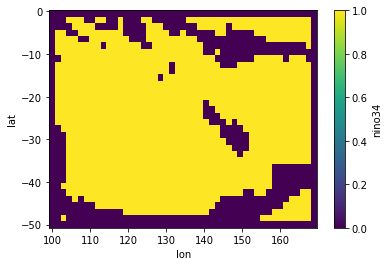

In [78]:
combined.nino34.plot()#shading='gouraud')

In [16]:
everythingXr

<xarray.DataArray 'everything' (model: 38, year: 249)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2094 2095 2096 2097 2098
  * model    (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'

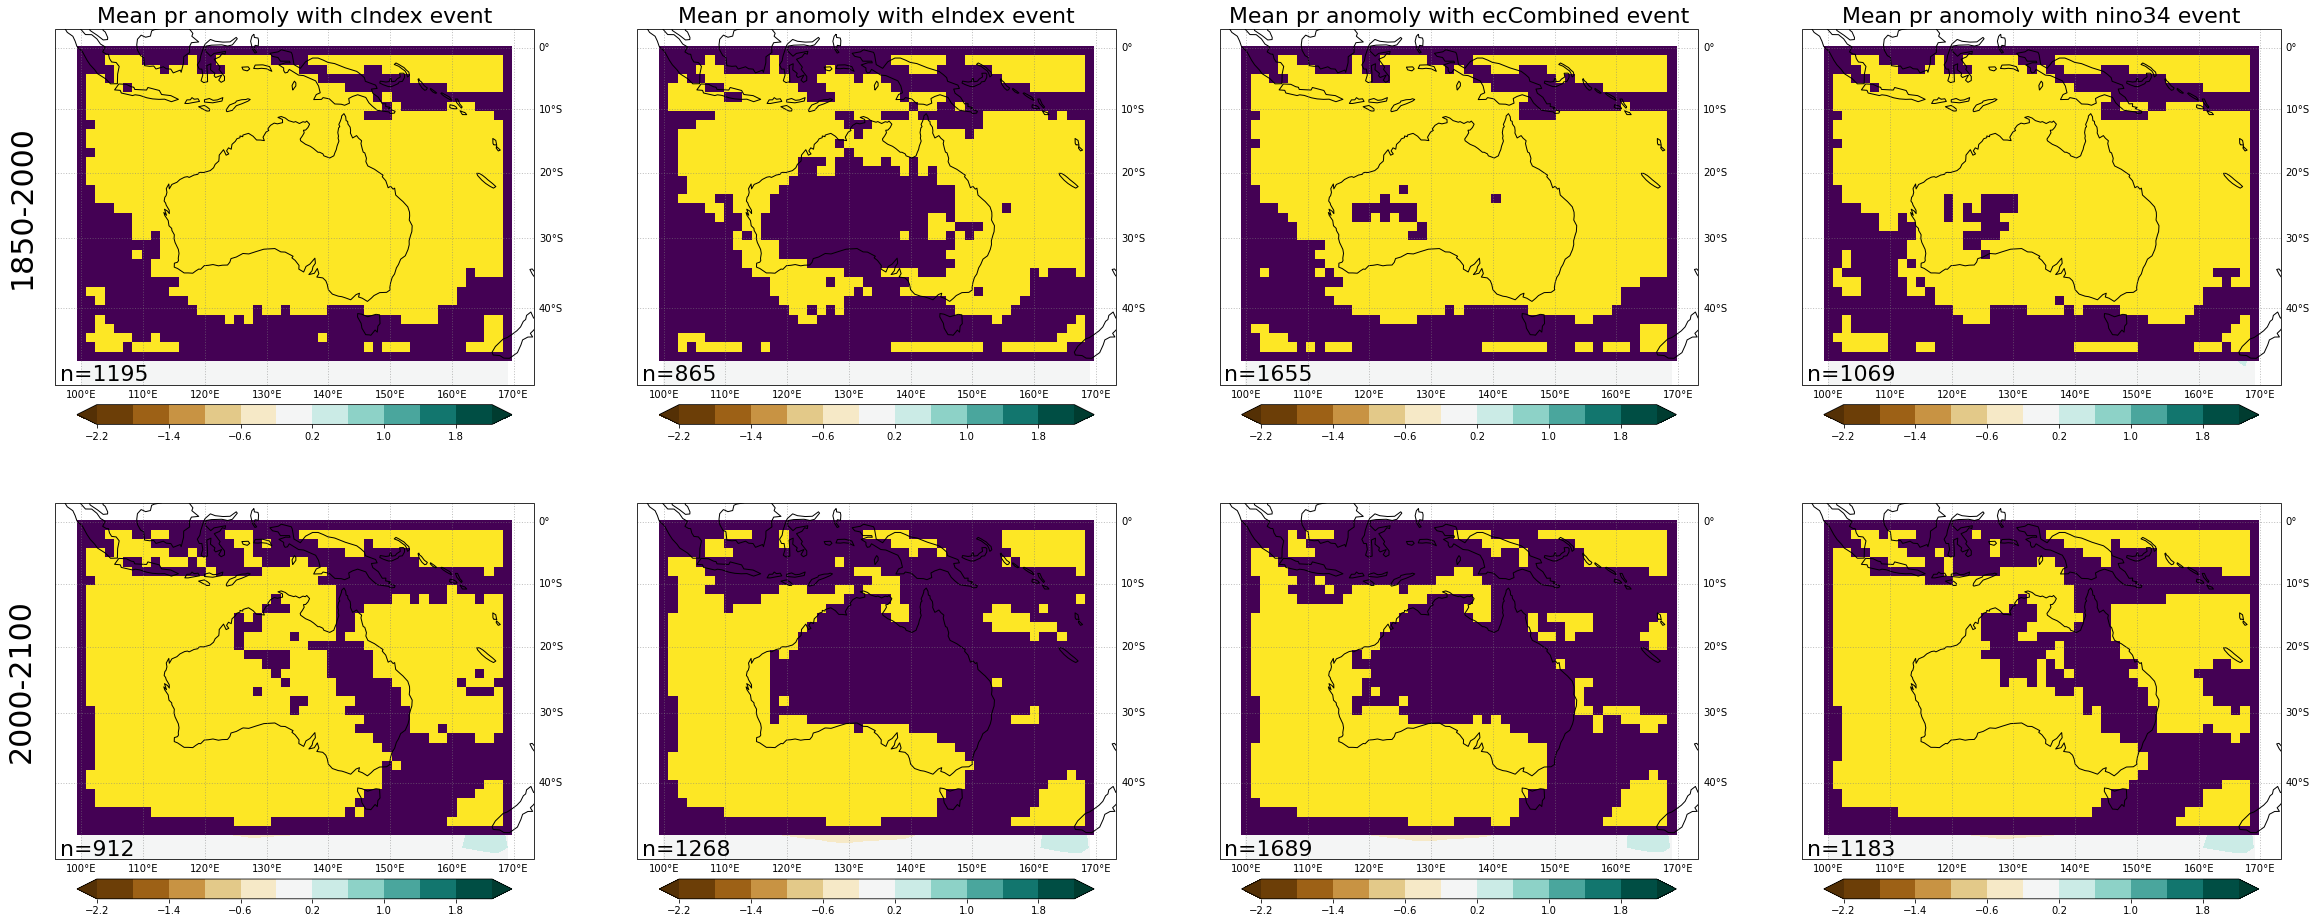

In [ ]:
# rainfall plots, fire Pos
multiPlotter(
    rainfallXr, 
    maskXr, 
    eventsList,
    resultsDir+'firePosPrec.png'
)


multiPlotter(
    tempXr, 
    maskXr, 
    eventsList, 
    resultsDir+'firePosTemp.png'
)

Do the differences over time

diffPlotter(
    rainfallXr.precAnom, 
    maskXr, 
    eventsList,
    'results/cesmImpactFigures/firePosPrecDiff.png'
)


diffPlotter(
    tempXr.tsAnom, 
    maskXr, 
    eventsList, 
    'results/cesmImpactFigures/firePosTempDiff.png'
)

And detrended

In [ ]:
multiPlotter(
    rainfallXr.rolling(year=11, center=True).mean('year'), 
    everythingXr.to_dataset(), 
    ['everything'],
    resultsDir+'firePosPrecTrend.png'
)

multiPlotter(
    tempXr.rolling(year=11, center=True).mean('year'), 
    everythingXr.to_dataset(), 
    ['everything'],
    resultsDir+'firePosTempTrend.png'
)

In [ ]:
# rainfall plots, fire Pos
multiPlotter(
    rainfallXr-rainfallXr.rolling(year=11, center=True).mean('year'), 
    maskXr, 
    eventsList,
    resultsDir+'firePosPrecDetrend.png'
)


multiPlotter(
    tempXr-tempXr.rolling(year=11, center=True).mean('year'), 
    maskXr, 
    eventsList, 
    resultsDir+'firePosTempDetrend.png'
)

What happens with reduced model set?

In [ ]:
firePos=allEvents.sel(fire='pos', experiment='ssp585', year=range(1850,2099), model=_model.wangModelSet ,drop=True)

In [ ]:
firePos

In [ ]:
eventsList=['cIndex','eIndex','ecCombined','nino34']
maskXr = (firePos[eventsList]==1)
everythingXr=(firePos['nino34'].isnull()==False)
everythingXr.name='everything'

In [ ]:
# rainfall plots, fire Pos
multiPlotter(
    rainfallXr, 
    maskXr, 
    eventsList,
    resultsDir+'firePosPrec.png'
)


multiPlotter(
    tempXr, 
    maskXr, 
    eventsList, 
    resultsDir+'firePosTemp.png'
)

# And again for Fire Neg

In [ ]:
fireNeg=allEvents.sel(fire='neg', experiment='ssp585', year=range(1850,2099),drop=True)

In [ ]:
eventsList=['cIndex','eIndex','ecCombined','nino34']
maskXr = (fireNeg[eventsList]==1)
everythingXr=(fireNeg['nino34'].isnull()==False)
everythingXr.name='everything'

In [ ]:
multiPlotter(
    rainfallXr, 
    maskXr, 
    eventsList,
    resultsDir+'fireNegPrec.png'
)


multiPlotter(
    tempXr, 
    maskXr, 
    eventsList, 
    resultsDir+'fireNegTemp.png'
)

And detrended

In [ ]:
# rainfall plots, fire Pos
multiPlotter(
    rainfallXr-rainfallXr.rolling(year=11, center=True).mean('year'), 
    maskXr, 
    eventsList,
    resultsDir+'fireNegPrecDetrend.png'
)


multiPlotter(
    tempXr-tempXr.rolling(year=11, center=True).mean('year'), 
    maskXr, 
    eventsList, 
    resultsDir+'fireNegTempDetrend.png'
)